In [30]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import cv2
import os

exec(open('../rawCode/Reconstructer_Classes.py').read())
exec(open('../rawCode/HelperFunctions.py').read())
exec(open('../rawCode/Filter_Classes.py').read())

train_data_names = pd.read_csv('../data/df_final_image_data.csv')
train_data_names['Date'] = pd.to_datetime(train_data_names['Date'])
from os import listdir
from os.path import isfile, join
my_path = 'D:\\Indas\\Preprocessed\\Preprocessed\\NOK_samples_xray\\004'

In [4]:
########################################################################################
######################### Define function for this script ##############################
########################################################################################

def evaluateErrorList(errMap, df):
    res_bool = []
    no_cl = []
    for i in range(len(errMap)):
        r_min, r_max,c_min, c_max = df.iloc[i][['row_min', 'row_max', 'col_min', 'col_max']]
        b, cl = evaluate_error_map(errMap[i] > 0, r_min, r_max, c_min, c_max)
        res_bool.append(b)
        no_cl.append(cl) 
    return(pd.DataFrame({'error_included': res_bool, 'number_of_clusters': no_cl}))

def MapDetectorPipeline(type, sg, nc, th, std_th, errG_op, errG_cl, errG_threshold, img_array_train, img_array_test):
    Reconstructer = pcaRecon(type, sg, nc)
    Reconstructer.fit(img_array_train)
    TrainReconstructions = np.array([Reconstructer.reconstruct(img_array_train[i,:,:]) for i in range(img_array_train.shape[0])])
    THFilter = threshold_filter(th)
    StdFilter = std_filter(std_th, 2)
    StdFilter.fit(TrainReconstructions, img_array_train)
    EgFilter = errGrowth_filter(errG_op, errG_cl, errG_threshold)
    mFilter = morphological_filter(1)
    del img_array_train
    del TrainReconstructions
    ErrTestReconstructions = [Reconstructer.reconstruct(img_array_test[i,:,:]) - img_array_test[i,:,:]  for i in range(img_array_test.shape[0])]
    th_filtered_TestReconstructions = [THFilter.filter(recon) for recon in ErrTestReconstructions]
    std_filtered_TestReconstructions = [StdFilter.filter(recon) for recon in th_filtered_TestReconstructions]
    eg_filtered_TestReconstructions = [EgFilter.filter(recon) for recon in std_filtered_TestReconstructions]
    del ErrTestReconstructions
    del th_filtered_TestReconstructions
    return([[mFilter.filter(std_fil) for std_fil in  std_filtered_TestReconstructions], eg_filtered_TestReconstructions] )

def ErrorlistsToEvaluatedDF(list_of_err_lists, test_informations, reconstruction_list, filter_method):
    df_list = []
    for i in range(len(list_of_err_lists)):
        tmp = evaluateErrorList(list_of_err_lists[i], test_informations).assign(
                Reconstruction = [reconstruction_list[i]] * len(list_of_err_lists[i]),
                Filter =  [filter_method] * len(list_of_err_lists[i]),
                Date = pd.to_datetime(test_informations.Date.values) )
        df_list.append(tmp)
    aug_mer_fil_maj = augmented_merge_majority_filter(3)
    aug_fil_err_maj_map =[aug_mer_fil_maj.filter_merge([list_of_err_lists[j][i] for j in range(len(list_of_err_lists))]) for i in range(len(list_of_err_lists[0]))]
    df_list.append(evaluateErrorList(aug_fil_err_maj_map, test_informations).assign(
                    Reconstruction = ['all'] * len(aug_fil_err_maj_map),
                    Filter =  [filter_method + ' maj'] * len(aug_fil_err_maj_map),
                    Date = pd.to_datetime(test_informations.Date.values) ))
    del aug_fil_err_maj_map
    aug_mer_fil = augmented_merge_filter(3)
    aug_fil_err_map =[aug_mer_fil.filter_merge([list_of_err_lists[j][i] for j in range(len(list_of_err_lists))]) for i in range(len(list_of_err_lists[0]))]
    df_list.append(evaluateErrorList(aug_fil_err_map, test_informations).assign(
                    Reconstruction = ['all'] * len(aug_fil_err_map),
                    Filter =  [filter_method + ' all'] * len(aug_fil_err_map),
                    Date = pd.to_datetime(test_informations.Date.values) ))
    del aug_fil_err_map
    return(pd.concat(df_list))  

In [5]:
########################################################################################
######################### FOR 2022-02-10 ###############################################
########################################################################################

Date_of_test = dt.datetime(2022, 2, 10)

idx_Date = (train_data_names['Date'] == Date_of_test)
idx_OK = train_data_names.group == 'OK'

img_arr_OK = np.array([
    cv2.imread( my_path + '\\' + img_name, cv2.IMREAD_GRAYSCALE) for  img_name in train_data_names.name[np.logical_and(idx_Date, idx_OK)].values
    ])
img_arr_NOK = np.array(
    [cv2.imread( my_path + '\\' + img_name, cv2.IMREAD_GRAYSCALE) for  img_name in train_data_names.name[np.logical_and(idx_Date, idx_OK.__invert__())].values
    ])
test_info = train_data_names[np.logical_and(idx_Date, idx_OK.__invert__())]

row_std, row_eG = MapDetectorPipeline('row', sg = 144, nc = 65, th =15, std_th = 3, errG_op = 1, errG_cl =3, errG_threshold = 5, img_array_train = img_arr_OK, img_array_test = img_arr_NOK )
col_std, col_eG = MapDetectorPipeline('col', sg = 96, nc = 35, th =15, std_th = 3, errG_op =1, errG_cl =3, errG_threshold = 5, img_array_train = img_arr_OK, img_array_test = img_arr_NOK )
sub_std, sub_eG = MapDetectorPipeline('sub', sg = 24, nc = 25, th =15, std_th = 3, errG_op =1, errG_cl =3, errG_threshold = 5, img_array_train = img_arr_OK, img_array_test = img_arr_NOK )

std_df = ErrorlistsToEvaluatedDF([row_std, col_std, sub_std],
                        test_info, ['row', 'col', 'sub'], 'std')
errG_df = ErrorlistsToEvaluatedDF([row_eG, col_eG, sub_eG],
                        test_info, ['row', 'col', 'sub'], 'ErrGrow')

In [11]:
std_df[std_df.error_included].sort_values(by = 'number_of_clusters').head()

,error_included,number_of_clusters,Reconstruction,Filter,Date
12,True,8,all,std all,2022-02-10
21,True,14,all,std all,2022-02-10
20,True,16,all,std all,2022-02-10
7,True,17,all,std all,2022-02-10
23,True,19,all,std all,2022-02-10


In [70]:
std_df[(std_df.error_included)].sort_values(by = 'number_of_clusters').tail()

,error_included,number_of_clusters,Reconstruction,Filter,Date
1,True,640,row,std,2022-02-10
0,True,742,sub,std,2022-02-10
0,True,778,row,std,2022-02-10
6,True,853,row,std,2022-02-10
4,True,1188,col,std,2022-02-10


In [56]:
augmMerMajFil = augmented_merge_majority_filter(3)
augmMerMajFilAll = augmented_merge_filter(3)

In [53]:
def heatmap_simple(gray_img, bool_err_map):
    img_tmp = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2RGB) 
    img_tmp[bool_err_map > 0, 1:3] = (img_tmp[bool_err_map > 0, 1:3] / 2) 
    img_tmp[bool_err_map > 0, 0] = 255
    plt.axis('off')
    plt.imshow(img_tmp)


# Bestcase STD

In [57]:
filt_img_12 = augmMerMajFil.filter_merge([row_std[12], sub_std[12], col_std[12]])
filt_img_12_all = augmMerMajFilAll.filter_merge([row_std[12], sub_std[12], col_std[12]])

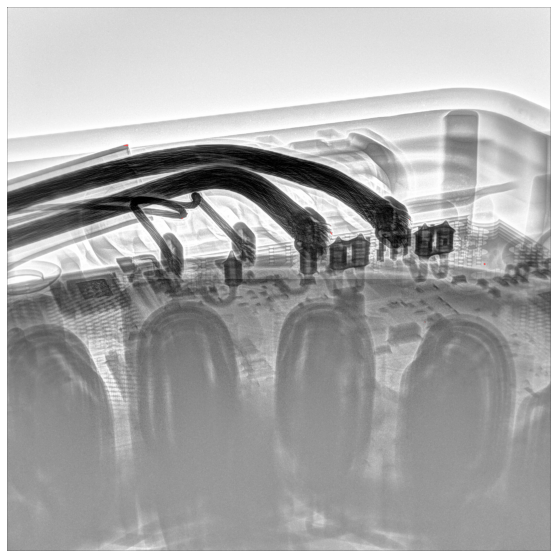

In [66]:
heatmap_simple(img_arr_NOK[12], filt_img_12_all)
plt.savefig('../plots/results_heatmap_std_best_10feb_Unanimity.png')

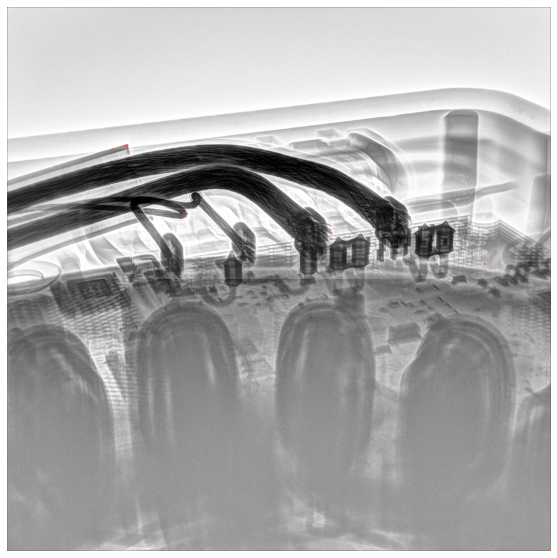

In [54]:
heatmap_simple(img_arr_NOK[12], filt_img_12)
plt.savefig('../plots/results_heatmap_std_best_10feb_Majority.png')

# Worst Case STD

In [59]:
filt_img_23 = augmMerMajFil.filter_merge([row_std[23], sub_std[23], col_std[23]])
filt_img_23_all = augmMerMajFilAll.filter_merge([row_std[23], sub_std[23], col_std[23]])

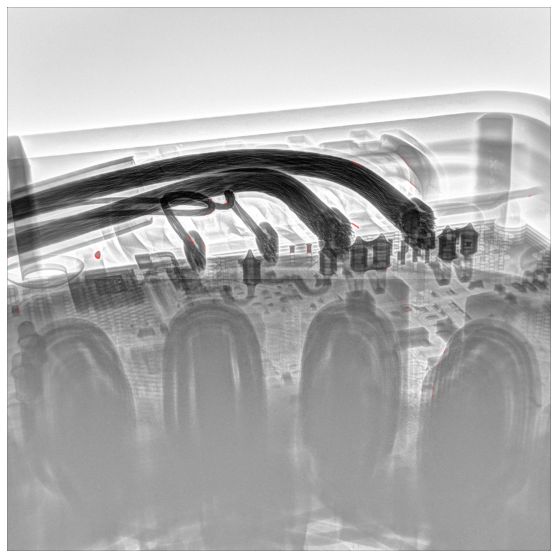

In [67]:
heatmap_simple(img_arr_NOK[23], filt_img_23)
plt.savefig('../plots/results_heatmap_std_worst_10feb_Majority.png')

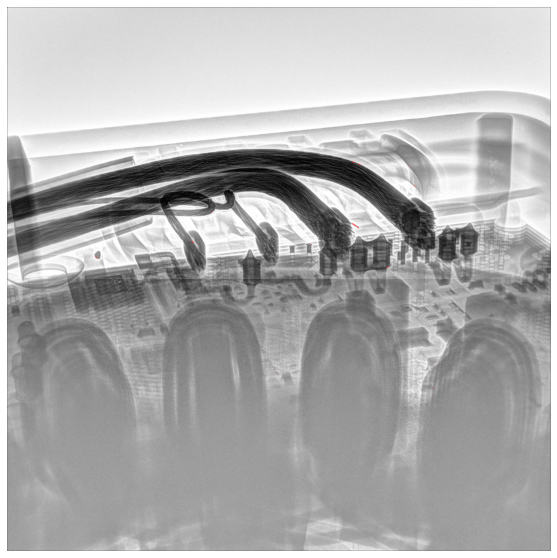

In [68]:
heatmap_simple(img_arr_NOK[23], filt_img_23_all)
plt.savefig('../plots/results_heatmap_std_worst_10feb_Unanity.png')

# Not included

In [100]:
std_df.Filter

0         std
1         std
2         std
3         std
4         std
       ...   
25    std all
26    std all
27    std all
28    std all
29    std all
Name: Filter, Length: 150, dtype: object

In [101]:
std_df[np.logical_and(std_df.error_included.__invert__(), std_df.Filter == 'std maj')].sort_values(by = 'number_of_clusters').tail(10)

,error_included,number_of_clusters,Reconstruction,Filter,Date
27,False,46,all,std maj,2022-02-10
13,False,53,all,std maj,2022-02-10
26,False,62,all,std maj,2022-02-10
24,False,67,all,std maj,2022-02-10
10,False,72,all,std maj,2022-02-10
15,False,77,all,std maj,2022-02-10
11,False,82,all,std maj,2022-02-10
17,False,112,all,std maj,2022-02-10
8,False,241,all,std maj,2022-02-10
4,False,577,all,std maj,2022-02-10


In [102]:
filt_img_8 = augmMerMajFil.filter_merge([row_std[8], sub_std[8], col_std[8]])
filt_img_8_all = augmMerMajFilAll.filter_merge([row_std[8], sub_std[8], col_std[8]])

In [104]:
rmin, rmax, cmin, cmax = test_info.loc[8]['row_min':'col_max']

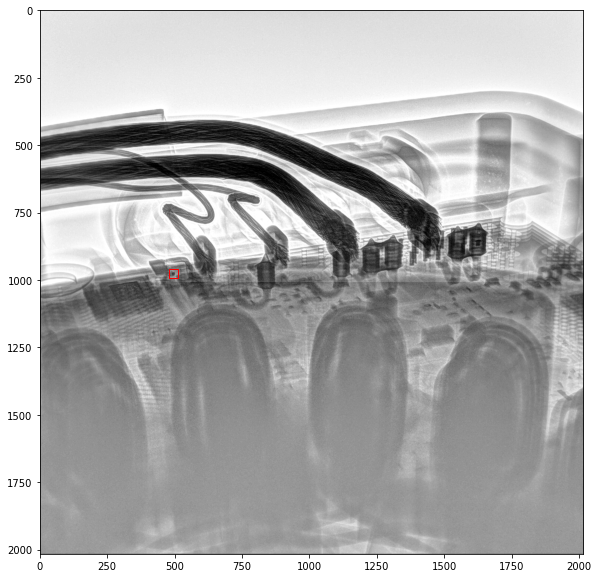

In [106]:
show_error(img_arr_NOK[8], rmin, rmax, cmin, cmax )

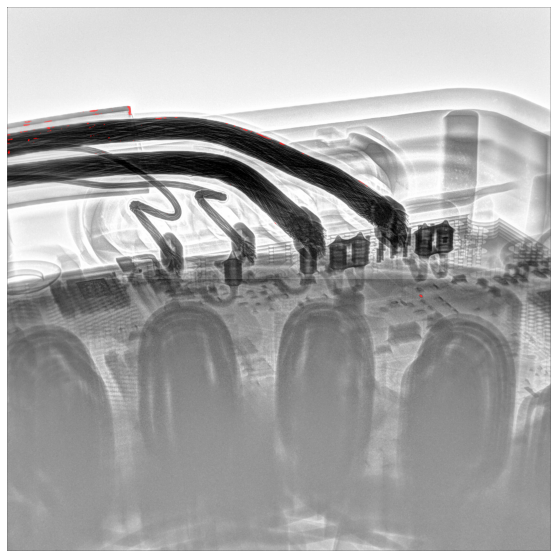

In [107]:
heatmap_simple(img_arr_NOK[8], filt_img_8_all)
plt.savefig('../plots/results_heatmap_std_NotDetected_10feb_Unanity.png')

# Best EG 

In [74]:
errG_df[np.logical_and(errG_df.error_included, errG_df.Reconstruction == 'all')].sort_values(by = 'number_of_clusters').head()

,error_included,number_of_clusters,Reconstruction,Filter,Date
18,True,3,all,ErrGrow all,2022-02-10
12,True,6,all,ErrGrow all,2022-02-10
20,True,7,all,ErrGrow all,2022-02-10
21,True,7,all,ErrGrow all,2022-02-10
14,True,7,all,ErrGrow all,2022-02-10


In [75]:
filt_img_18 = augmMerMajFil.filter_merge([row_eG[18], sub_eG[18], col_eG[18]])
filt_img_18_all = augmMerMajFilAll.filter_merge([row_eG[18], sub_eG[18], col_eG[18]])

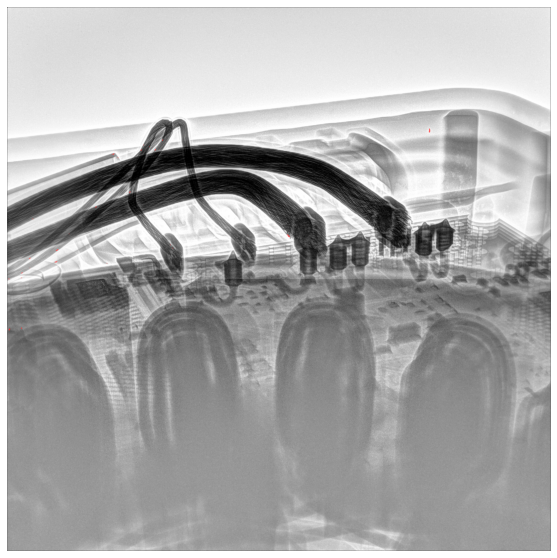

In [76]:
heatmap_simple(img_arr_NOK[18], filt_img_18)
plt.savefig('../plots/results_heatmap_eG_best_10feb_Majority.png')

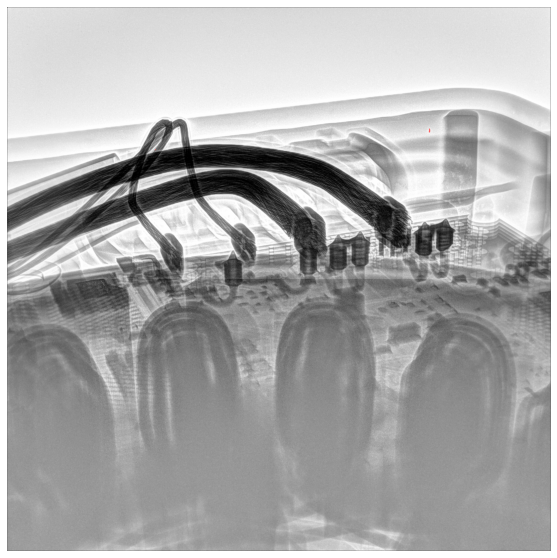

In [78]:
heatmap_simple(img_arr_NOK[18], filt_img_18_all)
plt.savefig('../plots/results_heatmap_eG_best_10feb_Unanity.png')

# Worst eG that include err

In [79]:
errG_df[np.logical_and(errG_df.error_included, errG_df.Reconstruction == 'all')].sort_values(by = 'number_of_clusters').tail()

,error_included,number_of_clusters,Reconstruction,Filter,Date
2,True,67,all,ErrGrow maj,2022-02-10
3,True,71,all,ErrGrow maj,2022-02-10
0,True,109,all,ErrGrow maj,2022-02-10
1,True,112,all,ErrGrow maj,2022-02-10
6,True,130,all,ErrGrow maj,2022-02-10


In [80]:
filt_img_6 = augmMerMajFil.filter_merge([row_eG[6], sub_eG[6], col_eG[6]])
filt_img_6_all = augmMerMajFilAll.filter_merge([row_eG[6], sub_eG[6], col_eG[6]])

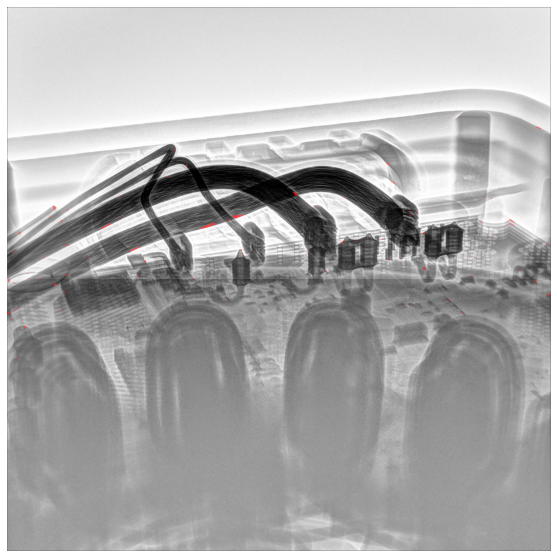

In [81]:
heatmap_simple(img_arr_NOK[6], filt_img_6)
plt.savefig('../plots/results_heatmap_eG_worst_10feb_Majority.png')

In [83]:
errG_df[np.logical_and(errG_df.error_included, errG_df.Filter == 'ErrGrow all')].sort_values(by = 'number_of_clusters').tail()

,error_included,number_of_clusters,Reconstruction,Filter,Date
23,True,9,all,ErrGrow all,2022-02-10
0,True,10,all,ErrGrow all,2022-02-10
7,True,10,all,ErrGrow all,2022-02-10
29,True,10,all,ErrGrow all,2022-02-10
28,True,12,all,ErrGrow all,2022-02-10


In [84]:
filt_img_28 = augmMerMajFil.filter_merge([row_eG[28], sub_eG[28], col_eG[28]])
filt_img_28_all = augmMerMajFilAll.filter_merge([row_eG[28], sub_eG[28], col_eG[28]])

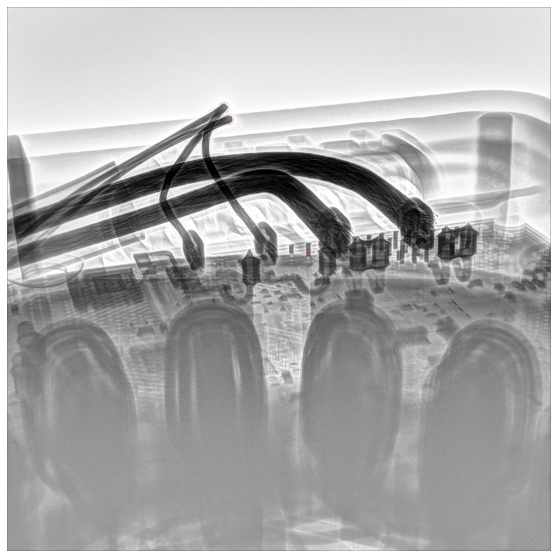

In [85]:
heatmap_simple(img_arr_NOK[28], filt_img_28_all)
plt.savefig('../plots/results_heatmap_eG_worst_10feb_Unanity.png')

In [36]:
img_12_col = cv2.cvtColor(img_arr_NOK[12].astype('uint8'), cv2.COLOR_GRAY2RGB) 
err_12_col = cv2.cvtColor(filt_img_12.astype('uint8'), cv2.COLOR_GRAY2RGB) 

In [45]:
img_12_col[filt_img_12 > 0, 1:3] = (img_12_col[filt_img_12 > 0, 1:3] / 2) 
# img_12_col[filt_img_12 > 0, 0] = filt_img_12[filt_img_12 > 0].astype('int') * 180

In [40]:
plt.rcParams['figure.figsize'] = [10, 10]

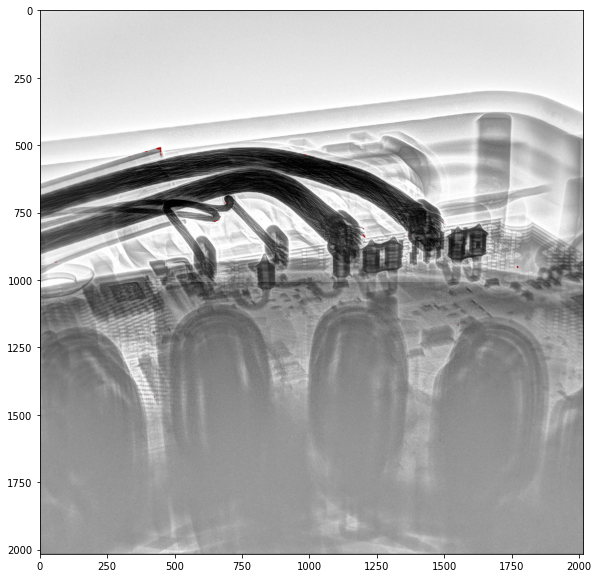

In [46]:
plt.imshow(img_12_col)
plt.savefig('../plots/results_heatmap_EG_best_10feb_Majority.png')